<a href="https://colab.research.google.com/github/tamahhamat/AI-project/blob/main/Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [1]:
!pip install pandas scikit-learn matplotlib


In [2]:
# load external libraries

from google.colab import drive, data_table
import os
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [3]:
# connect to google drive

from google.colab import drive
drive.mount('/content/drive')

# Set the path folder
PED_data_path = '/content/drive/MyDrive/AIdata/PED'

# Enable data table display for Pandas dataframes
data_table.enable_dataframe_formatter()


Mounted at /content/drive


# **Data**

**Demographics**

In [4]:
# Create an empty dataframe
columns = ["Participant", 'playedBefore', 'timePlaying', 'play', 'age', 'sex', 'country']
participant_df = pd.DataFrame(columns=columns)

# Iterate through participant folders
for participant_folder in os.listdir(PED_data_path):
    participant_path = os.path.join(PED_data_path, participant_folder)

    # Check if it's a directory
    if os.path.isdir(participant_path):
        # Get the list of files in the participant folder
        files_list = os.listdir(participant_path)

        # Initialize variables for additional information
        played_before = None
        time_playing = None
        play = None
        age = None
        sex = None
        country = None

        # Check if 'Dem.csv' file exists in the folder
        dem_file_path = os.path.join(participant_path, 'Dem.csv')
        if os.path.exists(dem_file_path):
            # Read the 'Dem.csv' file
            dem_df = pd.read_csv(dem_file_path, header=None, names=['A', 'B', 'C', 'D', 'E', 'F'])

            # Extract data from the dataframe
            row_data = dem_df.iloc[0]
            played_before = int(row_data['A'])
            time_playing = int(row_data['B'])
            play = int(row_data['C'])
            age = int(row_data['D'])
            sex = int(row_data['E'])
            country = row_data['F']

        # Add the folder name, file count,etc information to the dataframe
        new_row = pd.DataFrame({
            "Participant": [participant_folder],
            'playedBefore': [played_before],
            'timePlaying': [time_playing],
            'play': [play],
            'age': [age],
            'sex': [sex],
            'country': [country]
        })

        participant_df = pd.concat([participant_df, new_row], ignore_index=True)

# # Display the participant dataframe
# display(participant_df)

# Pivot the dataframe
pivoted_df = participant_df.pivot_table(index='Participant', aggfunc='first')

# # Display the pivoted dataframe
# display(pivoted_df)

**Preferences**

In [5]:
# Combined tables

# Create an empty DataFrame for combined data
combined_prefs_df = pd.DataFrame()

# Iterate through participant folders
for participant_folder in os.listdir(PED_data_path):
    participant_path = os.path.join(PED_data_path, participant_folder)

    # Check if it's a directory
    if os.path.isdir(participant_path):
        # Get the 'Pref.csv' file path for each participant
        prefs_file_path = os.path.join(participant_path, 'Pref.csv')

        # Check if 'Pref.csv' file exists
        if os.path.exists(prefs_file_path):
            # Read the 'Pref.csv' file
            prefs_df_participant = pd.read_csv(prefs_file_path, header=None)

            prefs_df_participant = prefs_df_participant.iloc[:, :10]

            # Rename the columns
            prefs_df_participant.columns = ['Game #', 'Level A Engagement', 'Level A Frustration', 'Level A Challenge', 'Level B Engagement', 'Level B Frustration', 'Level B Challenge', 'Engagement Preferences', 'Frustration Preferences', 'Challenge Preferences']

            # Add a new column for participant folder name
            prefs_df_participant.insert(0, 'Participant', participant_folder)

            # add participant data to the combined DataFrame
            if not combined_prefs_df.empty:
                combined_prefs_df = pd.concat([combined_prefs_df, pd.DataFrame([[''] * len(prefs_df_participant.columns)], columns=prefs_df_participant.columns)], ignore_index=True)
            combined_prefs_df = pd.concat([combined_prefs_df, prefs_df_participant], ignore_index=True)

# # Display the combined DataFrame
# display(combined_prefs_df)

**Gameplay**

In [6]:
# Function to combine data for all games played by a player into a single DataFrame
def combine_player_data(participant_folder):
    # Construct path to the participant folder
    participant_folder_path = os.path.join(PED_data_path, participant_folder)

    # List all game play CSV files in the participant folder
    csv_files = [file for file in os.listdir(participant_folder_path) if file.endswith('_A.csv') or file.endswith('_B.csv')]

    # Initialize empty list to store DataFrames for each game
    dfs = []

    # Iterate over each CSV file in the participant folder
    for csv_file in csv_files:
        # Construct path to the CSV file
        csv_file_path = os.path.join(participant_folder_path, csv_file)

        # Read the CSV file into a DataFrame
        try:
            df = pd.read_csv(csv_file_path, header=None, names=["time stamp", "action code"])
        except Exception as e:
            print(f"Error reading {csv_file_path}: {e}")
            continue

        # Replace NaN values with a placeholder
        df.fillna('NA', inplace=True)

        # get game number and level from the file name
        game_number, level = re.search(r'(\d+)_([AB])', csv_file).groups()

        # Add columns for player folder name, game file name, game number, level, and attempt number
        df['Participant'] = participant_folder
        df['Game'] = csv_file
        df['GameNumber'] = int(game_number)
        df['Level'] = level
        df['Attempt'] = (df['action code'].astype(str).str.lower().str.contains('level_start')).cumsum()

        # add the DataFrame to the list
        dfs.append(df)

    # combine all DataFrames in the list into a single DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)

    # Reorder columns
    combined_df = combined_df[['Participant', 'Game', 'GameNumber', 'Level', 'Attempt', 'time stamp', 'action code']]

    return combined_df

# List of participant folders
participant_folders = [
    'hec_22_03', 'nat_22_02', 'jul_23_03', 'par_16_03', 'jul_22_02', 'gog_10_03', 'jon_23_03', 'ili_07_12',
    'ele_07_12', 'gou_10_03', 'kat_16_03', 'mrn_22_02', 'pin_1_2', 'kar_14_03', 'des_22_02', 'kal_16_03',
    'jua_22_03', 'ema_14_02', 'ele_10_03', 'dar_22_03', 'ben_23_03', 'des_16_03', 'chr_22_03', 'ant_23_03',
    'asi_08_02', 'ama_16_03', '_teo_10_03', 'ril_22_02', 'kun_22_03', 'nel_1_2', 'mar_1_2', 'mar_23_03', 'nti_16_03',
    'dan-17-11', 'kal_08_02', 'mar_22_02', 'rik_22_02', 'ili_09_02', 'pen-17-11', 'leo_22_03', 'var_16_03', 'tro_22_03',
    '_jo2_23_03', '_em2_23_03', '_fot_14_03', 'yun_23_03', '_emi_23_03', 'cla_22_03', 'sta_10_03', 'tas_16_03',
    'sof_08_02', 'sig_22_02', '_dit_22_02', 'sar_10_03', 'the_08_02', 'ska_16_03', 'ste_04_03', 'sim_14_03', '_tol_11_03'
]

# create an empty list to store DataFrames for each participant
all_participant_dfs = []

# Iterate over each participant folder
for participant_folder in participant_folders:
    # Call the function to combine data for all games played by the participant
    combined_data = combine_player_data(participant_folder)

    # add the DataFrame to the list
    all_participant_dfs.append(combined_data)

# combine all DataFrames in the list into a single DataFrame for all participants
combined_all_participant_data = pd.concat(all_participant_dfs, ignore_index=True)

# # Display the combined DataFrame for all participants, games, and attempts
# display(combined_all_participant_data)

Merged Demographics and Preferences

In [7]:
# Merge the dataframes on 'Participant' column
combined_data = pd.merge(pivoted_df, combined_prefs_df, on='Participant', how='inner')

# # Display the combined dataframe
# display(combined_data)


# **Linear Regression**

**Level A**

In [8]:
# columns for prediction
selected_features_a = ['age', 'sex', 'play', 'playedBefore', 'timePlaying', 'Level A Challenge', 'Level A Frustration']
target_variable_a = 'Level A Engagement'

# columns from the combined data
selected_data_a = combined_data[[target_variable_a] + selected_features_a].dropna()

# Split the data into features (X) and target variable (y)
X_a = selected_data_a[selected_features_a]
y_a = selected_data_a[target_variable_a]

# Split the data into training and testing sets
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=0.2, random_state=42)

# Create a linear regression model
model_a = LinearRegression()

# Train model
model_a.fit(X_train_a, y_train_a)

# Make predictions
predictions_a = model_a.predict(X_test_a)

# Evaluate
mse_a = mean_squared_error(y_test_a, predictions_a)
r2_a = r2_score(y_test_a, predictions_a)

# Print evaluation metrics
print(f'Mean Squared Error (Level A): {mse_a}')
print(f'R-squared (Level A): {r2_a}')

# Print coefficients
print('Coefficients (Level A):', model_a.coef_)

# Include data
print('\nData Meaning:')
print('sex - 0=male, 1=female')
print('play - 0=yes, 1=no')
print('played before - 0=yes, 1=no')
print('time playing - 0-2 hours per week: 0, 2-5 hours per week: 1, 5-10 hours per week: 2, 10+ hours per week: 3')
print('Level challenge and Level frustration - Ranking Values: 0:Extremely, 1:Fairly, 2:Moderately, 3:Slightly, 4:Not at all')

Mean Squared Error (Level A): 0.6857311733112363
R-squared (Level A): 0.2637949336346279
Coefficients (Level A): [ 0.01130358  0.05634148 -0.27080378  0.15410871  0.18318724  0.3815707
 -0.08335532]

Data Meaning:
sex - 0=male, 1=female
play - 0=yes, 1=no
played before - 0=yes, 1=no
time playing - 0-2 hours per week: 0, 2-5 hours per week: 1, 5-10 hours per week: 2, 10+ hours per week: 3
Level challenge and Level frustration - Ranking Values: 0:Extremely, 1:Fairly, 2:Moderately, 3:Slightly, 4:Not at all


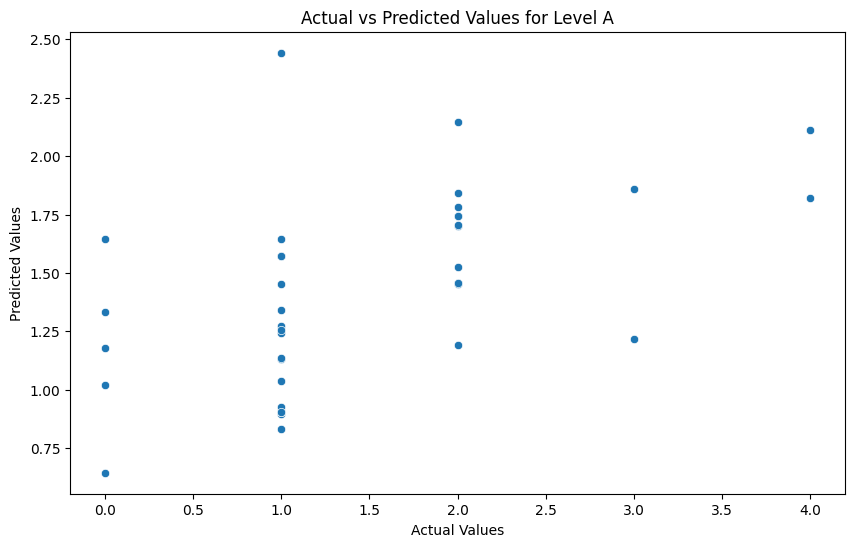

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_a, y=predictions_a)
plt.title('Actual vs Predicted Values for Level A')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

**Level B**

In [10]:
# columns for prediction
selected_features_b = ['age', 'sex', 'play', 'playedBefore', 'timePlaying', 'Level B Challenge', 'Level B Frustration']
target_variable_b = 'Level B Engagement'

# columns from the combined data
selected_data_b = combined_data[[target_variable_b] + selected_features_b].dropna()

# Split the data into features and target variable
X_b = selected_data_b[selected_features_b]
y_b = selected_data_b[target_variable_b]

# Split the data - training and testing
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

# Create model
model_b = LinearRegression()

# Train
model_b.fit(X_train_b, y_train_b)

# Make predictions
predictions_b = model_b.predict(X_test_b)

# Evaluate
mse_b = mean_squared_error(y_test_b, predictions_b)
r2_b = r2_score(y_test_b, predictions_b)

# Print metrics
print(f'Mean Squared Error (Level B): {mse_b}')
print(f'R-squared (Level B): {r2_b}')

# Print coefficients
print('Coefficients (Level B):', model_b.coef_)

# Include data meaning
print('\nData Meaning:')
print('sex - 0=male, 1=female')
print('play - 0=yes, 1=no')
print('played before - 0=yes, 1=no')
print('time playing - 0-2 hours per week: 0, 2-5 hours per week: 1, 5-10 hours per week: 2, 10+ hours per week: 3')
print('Level challenge and Level frustration - Ranking Values: 0:Extremely, 1:Fairly, 2:Moderately, 3:Slightly, 4:Not at all')

Mean Squared Error (Level B): 0.5923241108298958
R-squared (Level B): 0.33230599840876696
Coefficients (Level B): [-0.03902735 -0.11871098  0.33802223 -0.13015066 -0.07659257  0.37285939
  0.01623306]

Data Meaning:
sex - 0=male, 1=female
play - 0=yes, 1=no
played before - 0=yes, 1=no
time playing - 0-2 hours per week: 0, 2-5 hours per week: 1, 5-10 hours per week: 2, 10+ hours per week: 3
Level challenge and Level frustration - Ranking Values: 0:Extremely, 1:Fairly, 2:Moderately, 3:Slightly, 4:Not at all


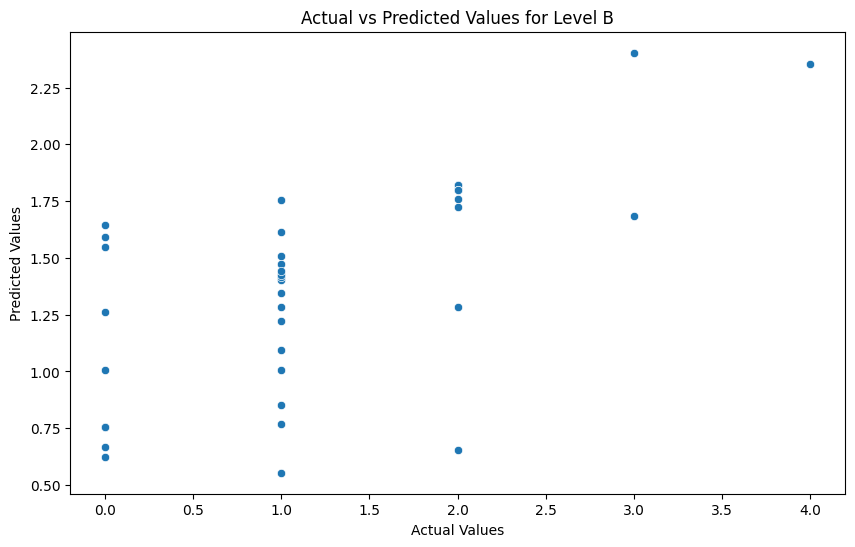

In [11]:


# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_b, y=predictions_b)
plt.title('Actual vs Predicted Values for Level B')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()